In [2]:
# Import libraries
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker

from japanmap import picture, pref_names

In [4]:
input_path = "../data/processed/housing_market_japan.csv"
df = pd.read_csv(input_path, encoding="utf-8")

In [3]:
english_to_japanese_pref = {
    "Hokkaido": "北海道",
    "Aomori": "青森県",
    "Iwate": "岩手県",
    "Miyagi": "宮城県",
    "Akita": "秋田県",
    "Yamagata": "山形県",
    "Fukushima": "福島県",
    "Ibaraki": "茨城県",
    "Tochigi": "栃木県",
    "Gunma": "群馬県",
    "Saitama": "埼玉県",
    "Chiba": "千葉県",
    "Tokyo": "東京都",
    "Kanagawa": "神奈川県",
    "Niigata": "新潟県",
    "Toyama": "富山県",
    "Ishikawa": "石川県",
    "Fukui": "福井県",
    "Yamanashi": "山梨県",
    "Nagano": "長野県",
    "Gifu": "岐阜県",
    "Shizuoka": "静岡県",
    "Aichi": "愛知県",
    "Mie": "三重県",
    "Shiga": "滋賀県",
    "Kyoto": "京都府",
    "Osaka": "大阪府",
    "Hyogo": "兵庫県",
    "Nara": "奈良県",
    "Wakayama": "和歌山県",
    "Tottori": "鳥取県",
    "Shimane": "島根県",
    "Okayama": "岡山県",
    "Hiroshima": "広島県",
    "Yamaguchi": "山口県",
    "Tokushima": "徳島県",
    "Kagawa": "香川県",
    "Ehime": "愛媛県",
    "Kochi": "高知県",
    "Fukuoka": "福岡県",
    "Saga": "佐賀県",
    "Nagasaki": "長崎県",
    "Kumamoto": "熊本県",
    "Oita": "大分県",
    "Miyazaki": "宮崎県",
    "Kagoshima": "鹿児島県",
    "Okinawa": "沖縄県"
}

# Mapping: Japanese prefecture names to japanmap code (0–47)
name_to_code = {name: code for code, name in enumerate(pref_names)}

# Convert values (e.g., count or mean) per English-prefecture-name into {pref_code: value}
def build_prefecture_value_dict(data: pd.Series) -> dict:
    """
    Convert a Series with English prefecture names into a dict of {japanmap_code: value}.

    Parameters:
        data (pd.Series): Index should be English-prefecture names, values can be count, mean, etc.

    Returns:
        dict: Mapping of japanmap prefecture code -> corresponding value.

    Example usage:
        # For average price per prefecture
        pref_mean = df.groupby("Prefecture")["Total transaction value"].mean()
        code_to_mean = build_prefecture_value_dict(pref_mean)

        # For number of records per prefecture
        pref_counts = df["Prefecture"].value_counts()
        code_to_count = build_prefecture_value_dict(pref_counts)
    """
    return {
        name_to_code[english_to_japanese_pref[pref]]: value
        for pref, value in data.items()
        if pref in english_to_japanese_pref and english_to_japanese_pref[pref] in name_to_code
    }


In [4]:
def plot_prefecture_colormap(pref_values, title="Prefecture Data Map", save_path=None, display=True):
    """
    Draws and optionally saves a choropleth map of Japan colored by values per prefecture.

    Parameters
    ----------
    pref_values : pandas.Series
        Series with prefecture names as index and numerical values (e.g., count, mean, median) as values.
    title : str, optional
        Title displayed at the top of the map.
    save_path : str or None, optional
        If a path is provided, the figure is saved to that location.
    display : bool, optional
        If True, the map will be shown in the notebook. Default is True.
    """
    import matplotlib.ticker as ticker

    # Define colormap and normalization based on the given values
    cmap = plt.get_cmap("Reds")
    norm = Normalize(vmin=0, vmax=pref_values.max())

    # Convert value to HEX color code using the colormap
    def value_to_hex(x):
        rgba = cmap(norm(x), bytes=True)[:3]
        return "#" + bytes(rgba).hex()

    # Create a mapping: prefecture name -> HEX color
    pref_color_hex = {pref: value_to_hex(val) for pref, val in pref_values.items()}

    # Convert prefecture names to codes and assign colors (external utility)
    code_to_color = build_prefecture_value_dict(pref_color_hex)

    # Generate the prefecture map image
    pic = picture(code_to_color)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(pic)
    plt.axis("off")
    plt.title(title, fontsize=14)

    # Add colorbar manually (custom position and size)
    cbar_ax = plt.gcf().add_axes([0.88, 0.1, 0.03, 0.8])
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.formatter = ticker.FuncFormatter(lambda x, _: f"{int(x):,}")
    cbar.update_ticks()

    # Save and/or display
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if display:
        plt.show()
    else:
        plt.close()


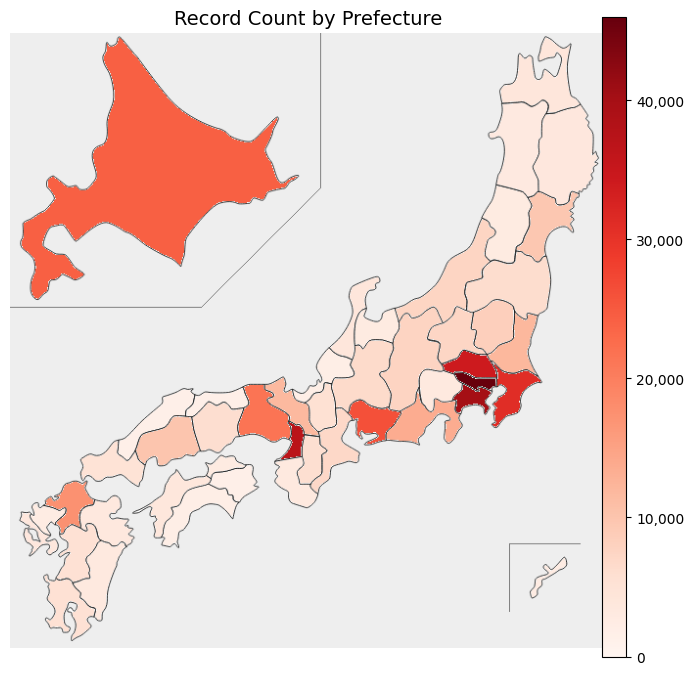

In [5]:
pref_counts = df["Prefecture"].value_counts()
plot_prefecture_colormap(
    pref_counts, 
    title="Record Count by Prefecture", 
    save_path="../results/figures/pref_map_data_count.png"
)


### Geographic Distribution of Records

The number of records is heavily concentrated in major urban areas such as the Kanto region (including Tokyo), Kansai, Aichi, Fukuoka, and Hokkaido. In contrast, rural prefectures tend to have fewer records.

However, to ensure balanced representation, we selected data from five years in which each prefecture had at least 200 records per year. This preprocessing step guarantees that every prefecture has a minimum of approximately 1,000 records in total.

Despite this effort, the dataset still reflects real-world population and transaction density differences across regions. Therefore, appropriate weighting may be necessary when performing aggregated calculations or training models to avoid bias toward high-density regions.


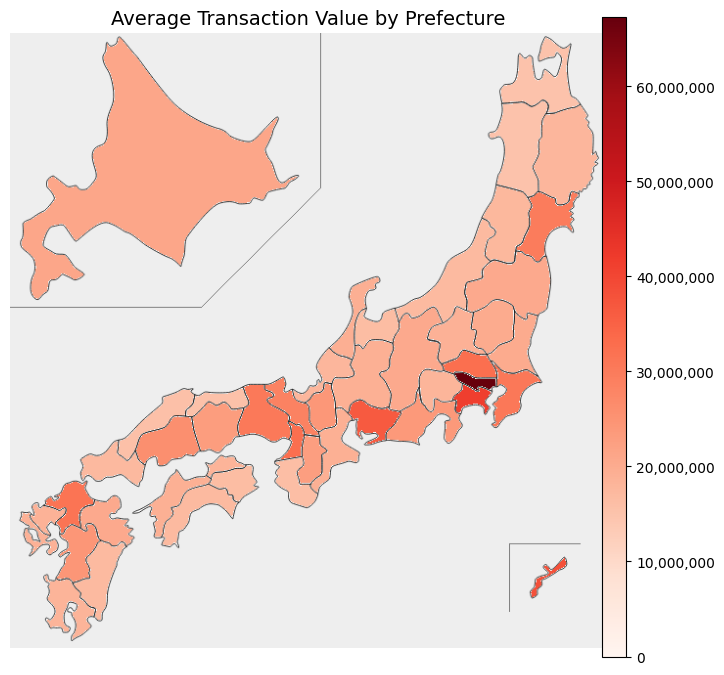

In [6]:
mean_price_by_pref = df.groupby("Prefecture")["Total transaction value"].mean()

plot_prefecture_colormap(
    mean_price_by_pref,
    title="Average Transaction Value by Prefecture",
    save_path="../results/figures/pref_map_avg_price.png"
)


### Average Transaction Value by Prefecture

Similar to the record count distribution, the average transaction values are generally higher in major urban areas such as Tokyo, Osaka, Aichi, and Fukuoka. However, because this map shows mean values rather than counts, the differences between regions appear more moderate.

That said, when interpreting or aggregating these statistics, it is important to consider the difference in confidence intervals due to varying sample sizes across prefectures. In such cases, weighting by the number of records per region may be necessary to obtain more reliable national-level estimates.
